# Simulation of Bock (1986) experiment
### Simulation 12

### Set-up

In [3]:
import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import syntactic_wm as cjn ## Our model
reload(cjn)


################
## Parameters ##
################
num_steps = 10 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 1 # number of epochs each sentence is presented to the model.

lambda_cc = 50 # learning rate of short-term synaptic plasticity amongst role neurons.
lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 1 #0.5 # factor dampening connectivity amongst role neurons.

k_cc = 4 # negative bias, i.e. negative k_cc is the floor of c-c connections.
epsilon_cc = 0.75 # the ceiling of c-c connections when without long-term encoding. 

k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.
epsilon_cf = 1.5 # the ceiling of c-f connections when without long-term encoding. 

h = 6 # normalising factor for inhibition between c-f connections.

W_mc = 2 # connectivity between morph and role neurons (non-encodable)
W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -1.5  # connectivity amongst word neurons (non-encodable)

unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

k_L_cc = 4.5 # long-term encoding amongst role neurons 
k_L_cf = 1.7 # long-term encoding between role and word neurons

k_L_cf_closed_class = 1.45 # long-term encoding between role and word neurons when the word belongs to a closed class
closed_class_word_roles = [[4,4],[6,6]] # define the closed class words

# also note that seed will not have an effect on recall unless noise is added to the network.
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

We will next define the priming sentences, both in active and passive voices. <br>
We will also define the 'target picture' which is a bag of words all encoded to the network simultaneously.

In [11]:
# long-term encodings
# The agent chased patient (Active) ## 0-1-2-3
# vs
# The patient was chased by agent (Passive) ## 0-1-4-2-5-3
LT_wc_knowledge = [[0,0], # the
                   [1,1], # noun1 -- subject
                   [1,3], # noun1 -- object (pt)
                   [1,7], # noun1 -- object (ag)
                   [2,2], # verb1 -- verb
                   [2,5], # verb1 -- verb
                   [3,1], # noun2 -- subject
                   [3,3], # noun2 -- object (pt)
                   [3,7], # noun2 -- object (ag)
                   [4,4], # were
                   [6,6], # by
                   [7,1], # noun3 -- subject
                   [7,3], # noun3 -- obj (pt)
                   [7,7], # noun3 -- obj (ag)
                   [5,2], # verb2 -- verb
                   [5,5], # verb2 -- verb
                   [8,1], # noun4 -- subject
                   [8,3], # noun4 -- obj (pt)
                   [8,7]  # noun4 -- obj (ag)
                  ] 
LT_cc_knowledge = [[0,1,2,3], #subject -> verb -> object
                   [0,1,4,5,6,7]] #subject -> was verb by -> object

morph_nodes = [1,3,7] # 1 is semantic tag for subject role (both ag and pt), 3 is semantic tag for pt object and 7 is semantic tag for ag object

num_steps = 10 # number of time steps taken by each word input.

### Priming - active voice sentence
sentence_prime_act = [] 
for n in range(head): sentence_prime_act.append(cjn.in_in())
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=0))
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=1)) # subject is noun1
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=2)) # verb1
for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=3)) # noun2 is object (pt)
for n in range(tail): sentence_prime_act.append(cjn.in_in())

### Priming - passive voice sentence
sentence_prime_pass = [] 
for n in range(head): sentence_prime_pass.append(cjn.in_in())
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=0))
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=3)) # subject is noun2
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=4)) 
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=2)) # verb1
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=6)) 
for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=1)) # noun1 is obj (ag)
for n in range(tail): sentence_prime_pass.append(cjn.in_in())


In [12]:
# priming sentence can be either active or passive voice
# for this example, we will be using the passive voice sentence
# sentence = sentence_prime_act
sentence = sentence_prime_pass

no_periods = 1 # number of epochs each sentence is presented to the model.
num_steps = 10
## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       morph_nodes = morph_nodes,
                       closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
                       closed_class_word_roles = closed_class_word_roles
                      )


# running the encoding phase - encoding the priming sentence
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  81
********************


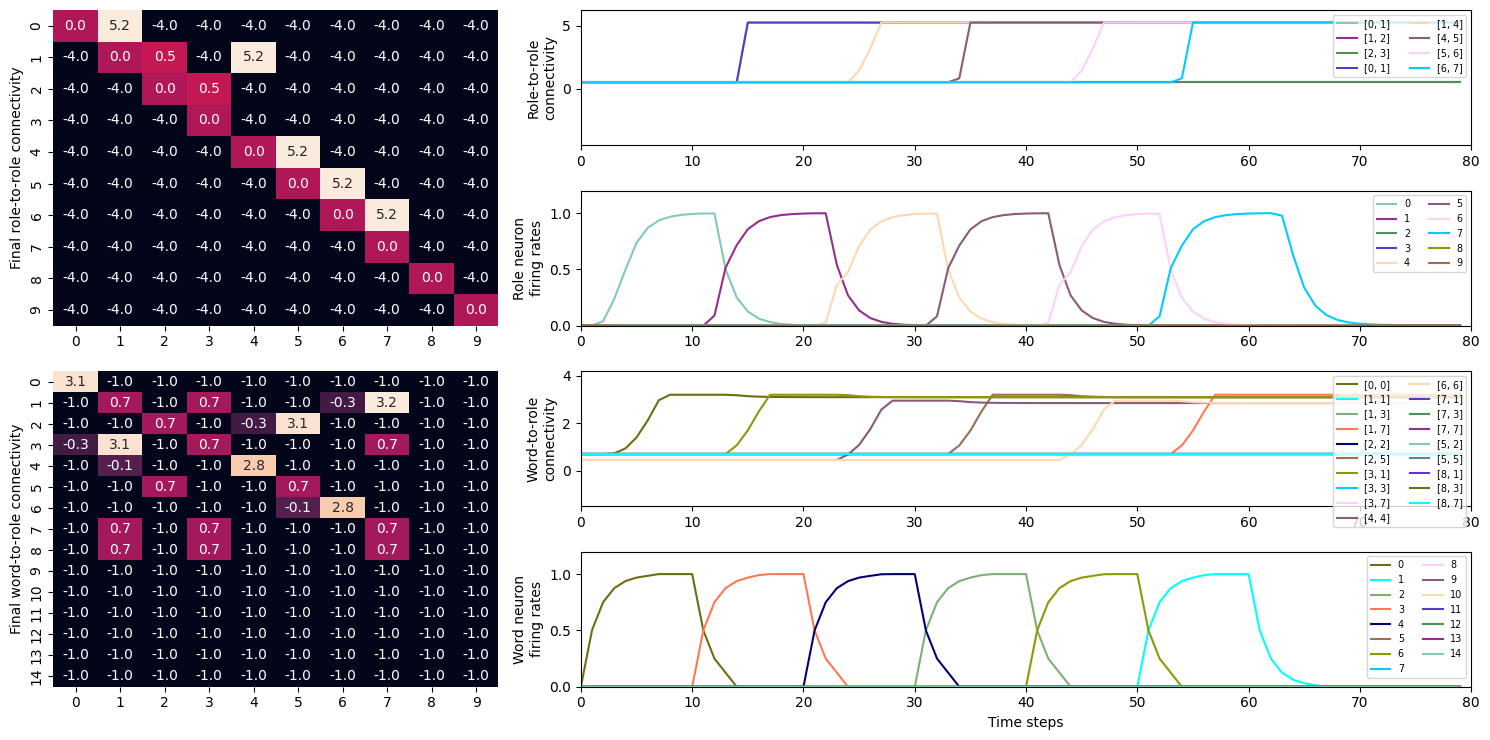

In [13]:
cjn.plot_results(sentence, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx,no_periods=no_periods)

In [14]:
no_periods = 15 # binding 

# input for binding
pre_sentence_1 = []
for n in range(20): pre_sentence_1.append(cjn.in_in())
for n in range(2): pre_sentence_1.append(cjn.in_in(word=7,morpheme=[1,7]))
for n in range(20): pre_sentence_1.append(cjn.in_in())
for n in range(2): pre_sentence_1.append(cjn.in_in(word=8,morpheme=[1,3]))
for n in range(20): pre_sentence_1.append(cjn.in_in())
for n in range(2): pre_sentence_1.append(cjn.in_in(word=5))
    
# during this phase, the learning rate within roles layer is switched to zero.
for n in range(n_role_neurons): # parent index
    for i in range(n_role_neurons): # child index
        WM_ori.cc_conn_dict[str(n)+str(i)].LR = 0 # switching off encoding between role neurons
    
sentence = pre_sentence_1
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori,time_steps=len(sentence)*no_periods,sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  66
********************
Epoch = 2
Number of recorded time steps:  132
********************
Epoch = 3
Number of recorded time steps:  198
********************
Epoch = 4
Number of recorded time steps:  264
********************
Epoch = 5
Number of recorded time steps:  330
********************
Epoch = 6
Number of recorded time steps:  396
********************
Epoch = 7
Number of recorded time steps:  462
********************
Epoch = 8
Number of recorded time steps:  528
********************
Epoch = 9
Number of recorded time steps:  594
********************
Epoch = 10
Number of recorded time steps:  660
********************
********************
Epoch = 11
Number of recorded time steps:  726
********************
Epoch = 12
Number of recorded time steps:  792
********************
Epoch = 13
Number of recorded time steps:  858
********************
Epoch = 14
Number of recorded time steps:  924
********************
Epoch = 15
Numbe

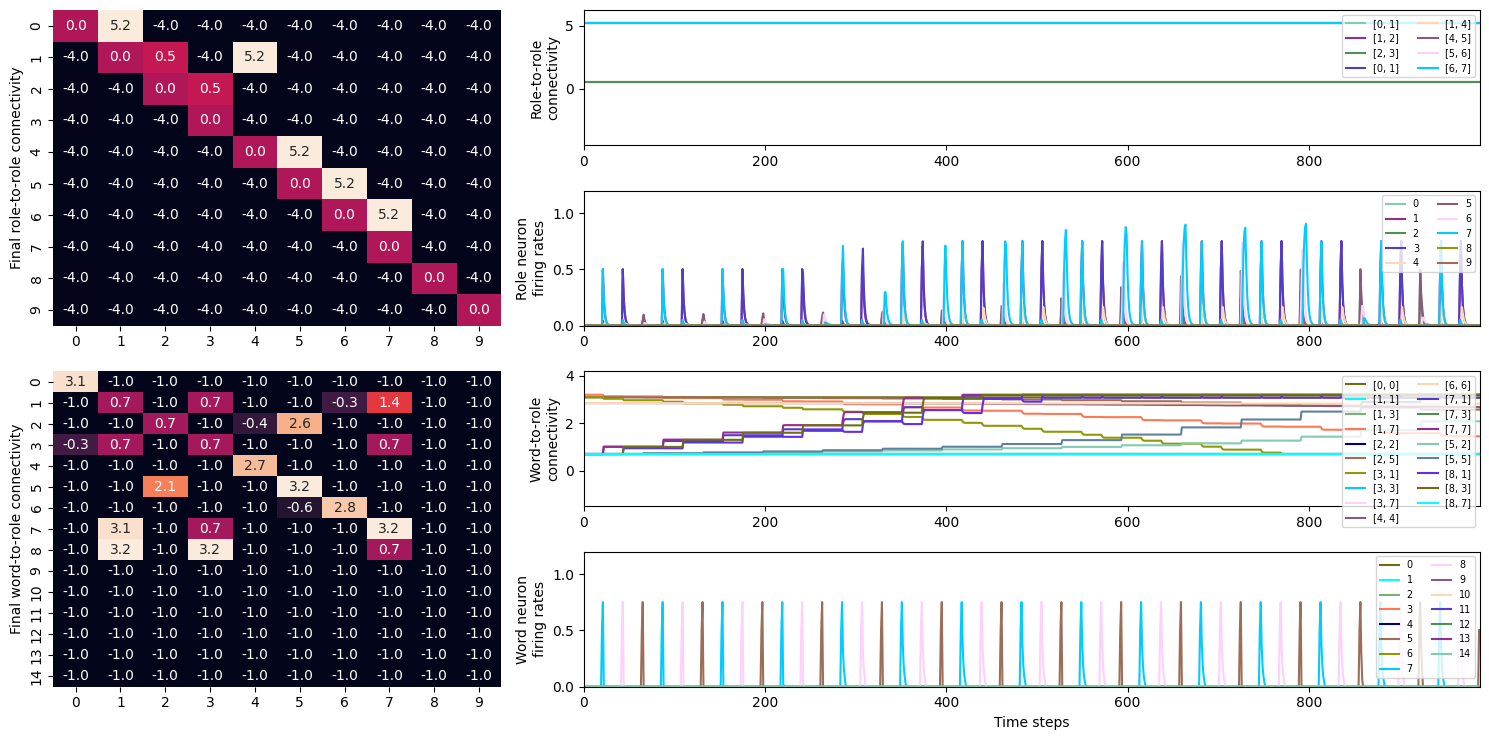

In [15]:
cjn.plot_results(sentence, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx,no_periods=no_periods)

The next step is to present the network with the bag words from the 'target picture'. <br>
Some of the parameters are adjusted to allow serialisation.

In [16]:
WM = deepcopy(WM_ori) # copy the network first
# Note role neurons encoding remain switched off.

no_periods = 1 # encoding 'target picture' over 1 epoch
num_steps = 20

# during this phase, the learning rate within roles layer is switched to zero.
for n in range(n_role_neurons): # parent index
    for i in range(n_role_neurons): # child index
        WM.cc_conn_dict[str(n)+str(i)].LR = 0 # switching off encoding between role neurons

auto_gramm = True # turning on serialisation
WM.auto_gramm = auto_gramm
for n in range(n_role_neurons):
    WM.role_neuron_dict[str(n)].auto_gramm = auto_gramm
for n in range(n_word_neurons):
    WM.word_neuron_dict[str(n)].auto_gramm = auto_gramm

### Target picture
sentence_target = []
for n in range(head): sentence_target.append(cjn.in_in())
for n in range(2): sentence_target.append(cjn.in_in(word=0))
for n in range(num_steps): sentence_target.append([cjn.in_in(word=5),cjn.in_in(word=7),cjn.in_in(word=8)]) # cjn.in_in(word=4) ,cjn.in_in(word=6)
for n in range(tail): sentence_target.append(cjn.in_in())
    
sentence = sentence_target # bag of words
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM,time_steps=len(sentence)*no_periods,sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  43
********************


Let's visualise the encoding resulting from "Target Picture" phase.

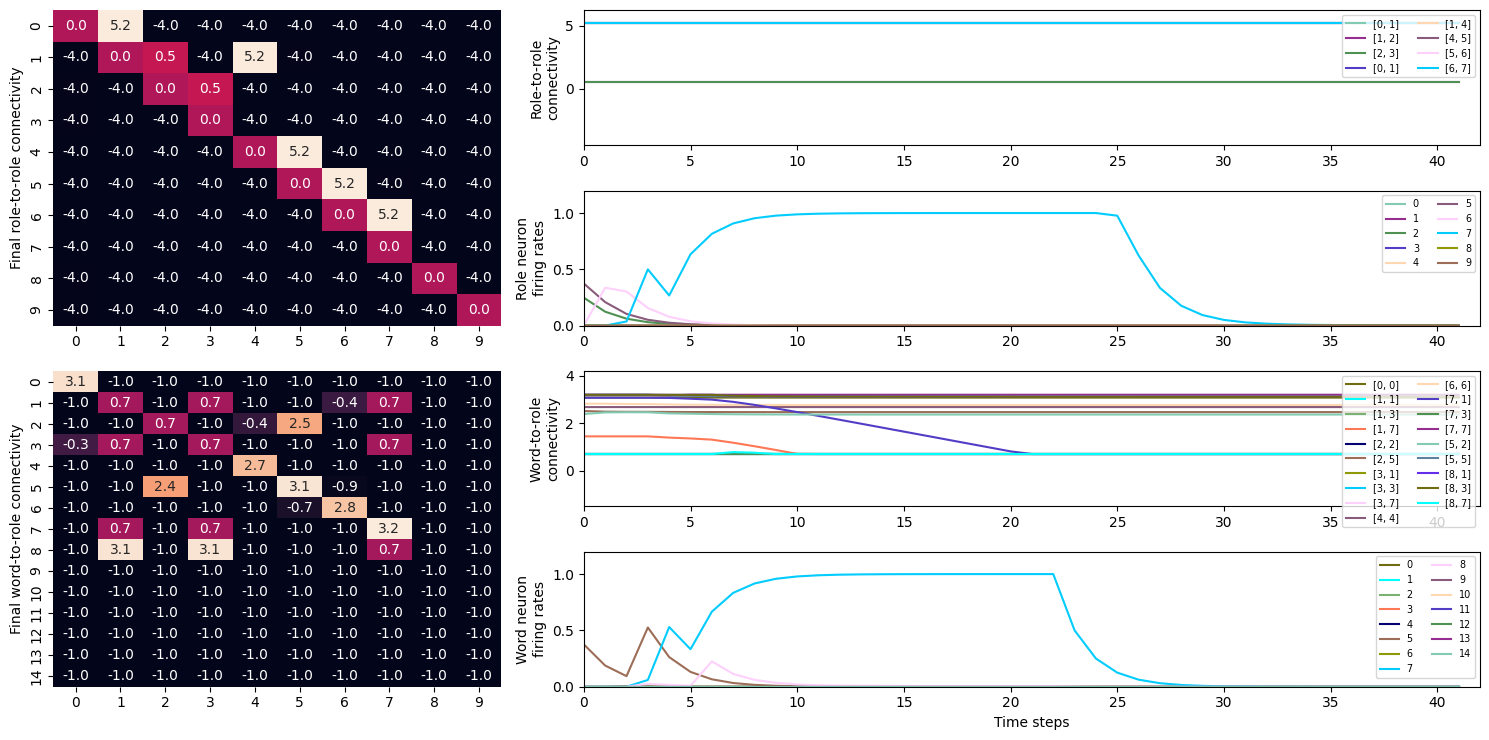

In [17]:
cjn.plot_results(sentence, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx,no_periods=no_periods)

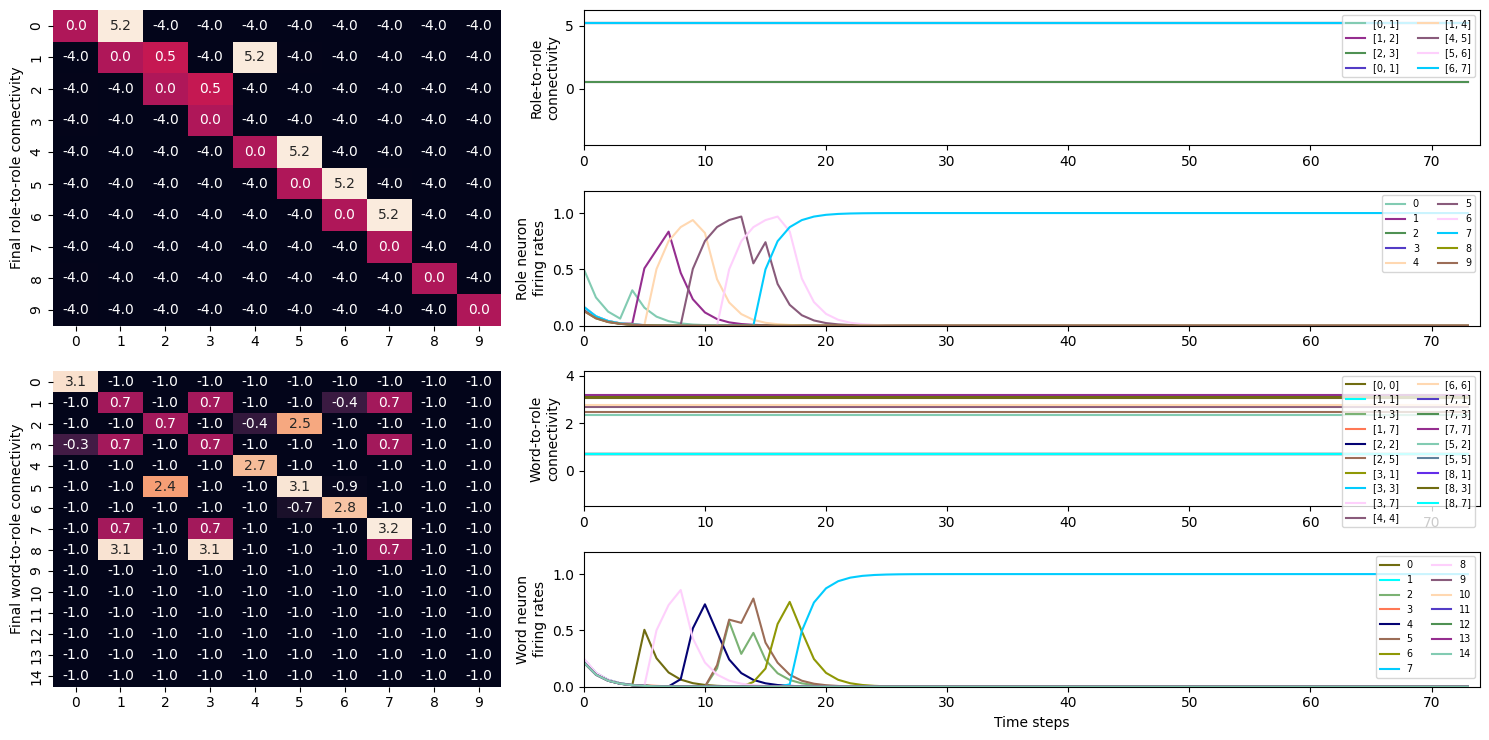

The final recall output is: 
[[8.0], [0.0], [8.0], [4.0], [5.0], [6.0], [7.0]]


In [18]:
WM_r = deepcopy(WM) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

In [26]:
# long-term encodings
LT_wc_knowledge = [[0,0], # the
                   [1,1], # dogs
                   [2,2], # eat
                   [3,3], # were
                   [2,4] # eat-ing
                  ] 
LT_cc_knowledge = [[0,1,2], #art -> noun -> active verb
                   [0,1,3,4]] #art -> noun -> aux -> participle

morph_nodes = [2,3,4] # 3 as aux identifier, 4 is -ing

lambda_cc = 50 
lambda_cf = 1

In [30]:
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

auto_gramm = True

# building the sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(30): sentence.append([cjn.in_in(word=1),cjn.in_in(word=3,morpheme=3),cjn.in_in(word=4,morpheme=4)]) 
# for n in range(30): sentence.append([cjn.in_in(word=1),cjn.in_in(word=2,morpheme=2)]) 
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       morph_nodes = morph_nodes,
                       closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
                       closed_class_word_roles = closed_class_word_roles,
                       auto_gramm = auto_gramm
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  61
********************


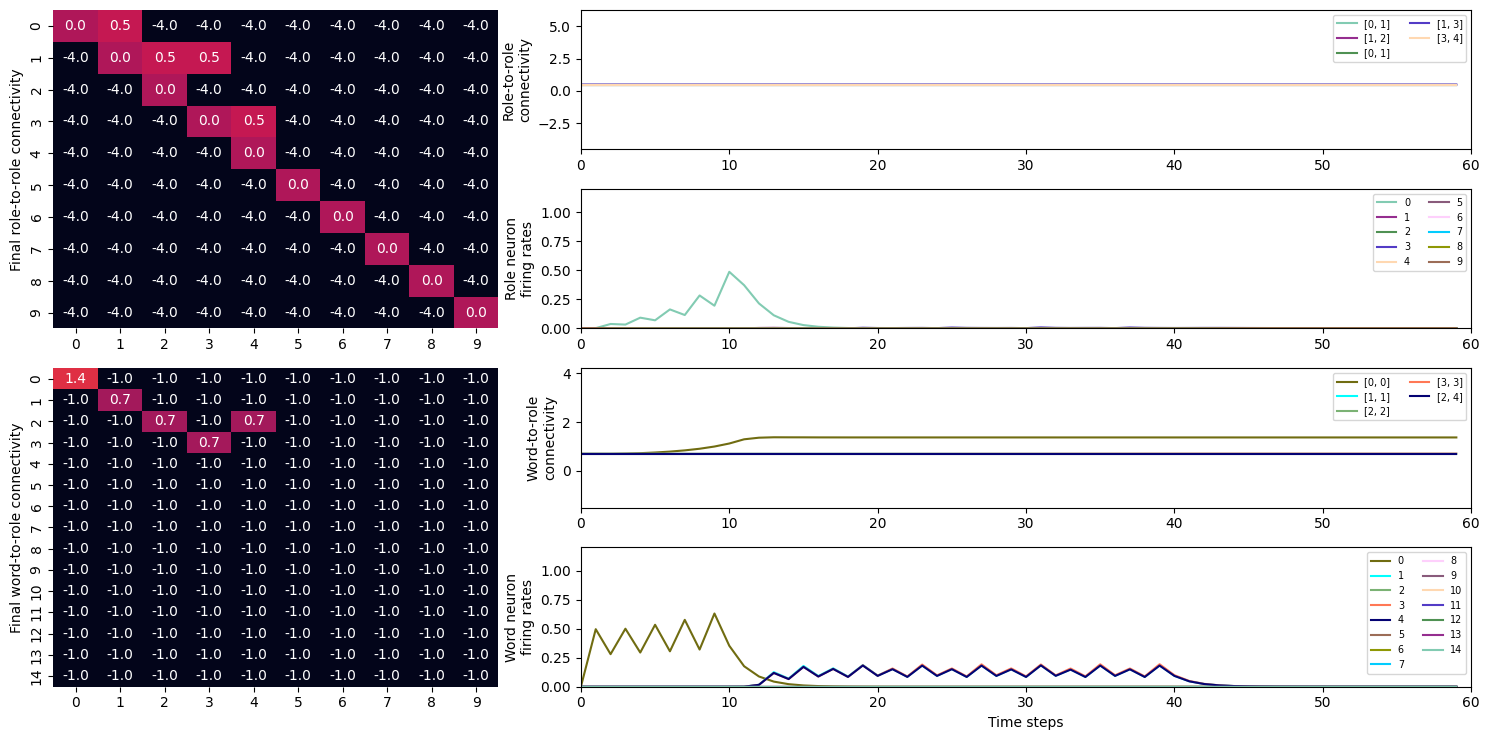

In [31]:
cjn.plot_results(sentence, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx,no_periods=no_periods)

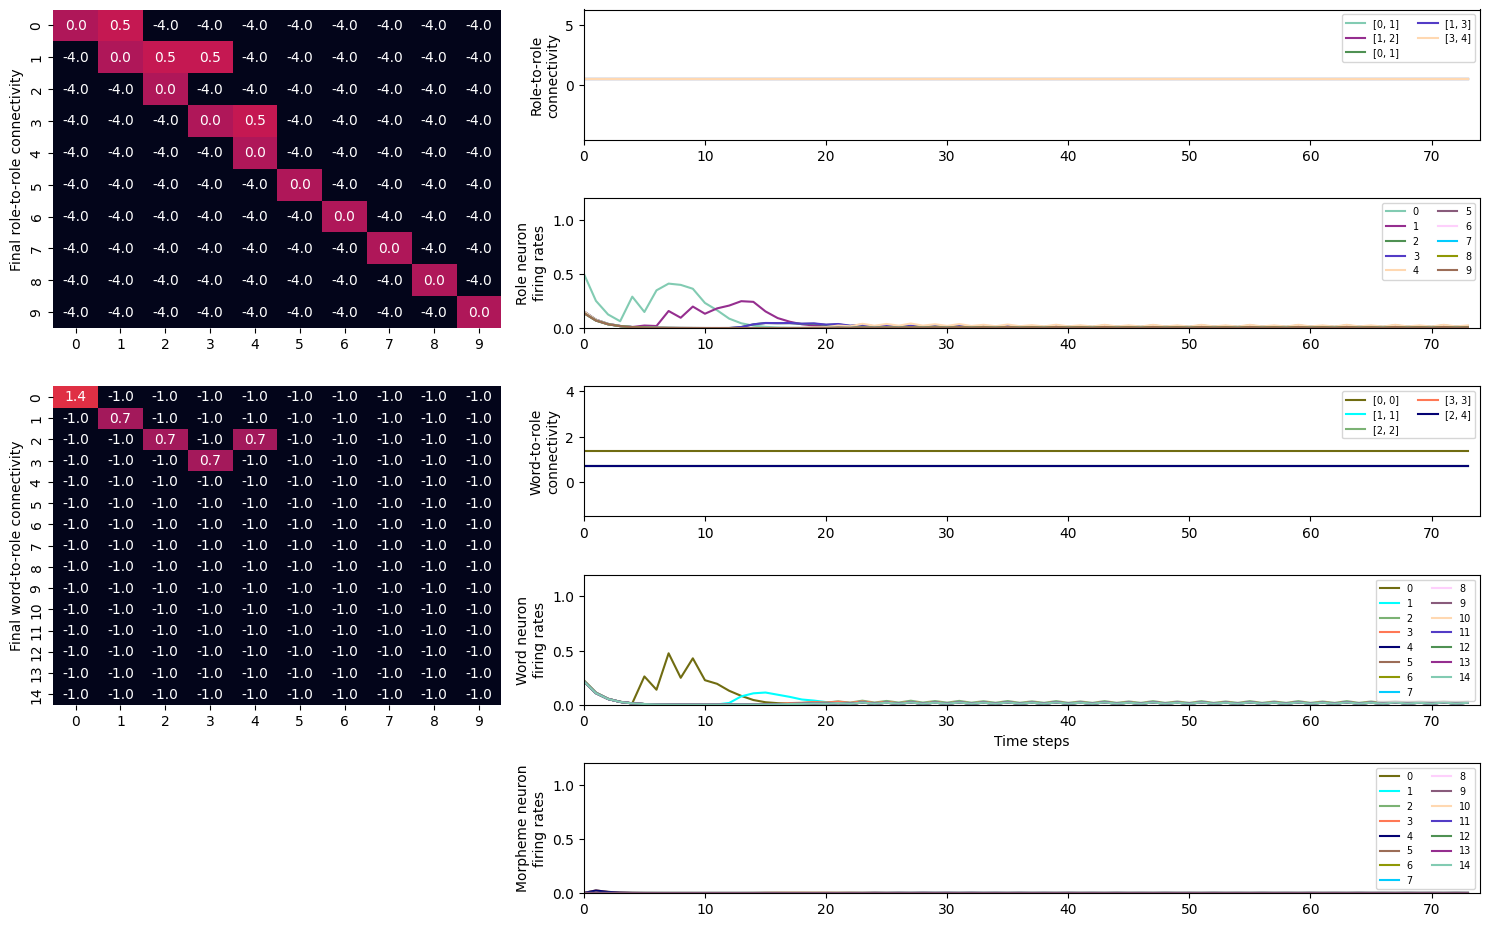

The final recall output is: 
[[2.0], [0.0], [1.0], [2.0]]


In [32]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r, morph_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

### Repeat syntactic priming experiments

In [230]:
# passive_check = [[8.0],[5.0],[7.0]]
# active_check = [[7.0],[5.0],[8.0]]
# passive_count_act = 0
# active_count_act = 0

# for seed_ in range(1000):
#     num_steps = 10 # number of time steps taken by each word input.
#     head = 1 # number of time steps buffering the front of each sentence.
#     tail = 20 # number of time steps buffering the end of each sentence.
#     no_periods = 1 # number of epochs each sentence is presented to the model.

#     lambda_cc = 50 # learning rate of short-term synaptic plasticity amongst role neurons.
#     lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

#     tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

#     beta = 1 # decay factor of firing rates.

#     n_word_neurons = 15 # number of word neurons initialised (f)
#     n_role_neurons = 10 # number of role neurons initialised (c)

#     gamma = 1 # factor dampening connectivity amongst role neurons.

#     k_cc = 4 # negative bias, i.e. negative k_cc is the floor of c-c connections.
#     epsilon_cc = 0.75 # the ceiling of c-c connections when without long-term encoding. 

#     k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.
#     epsilon_cf = 1.5 # the ceiling of c-f connections when without long-term encoding. 

#     h = 6 # normalising factor for inhibition between c-f connections.

#     W_mc = 2 # connectivity between morph and role neurons (non-encodable)
#     W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

#     W_ff = -1.5  # connectivity amongst word neurons (non-encodable)

#     unified_noise = 1.5 # noise level if noise is present
#     cc_noise = True # any noise amongst role neurons
#     wc_noise = True # any noise between role and word neurons

#     k_L_cc = 4.5 # long-term encoding amongst role neurons 
#     k_L_cf = 1.7 # long-term encoding between role and word neurons
    
#     k_L_cf_closed_class = 1.45 # long-term encoding between role and word neurons when the word belongs to a closed class
#     closed_class_word_roles = [[4,4],[6,6]] # define the closed class words

#     # also note that seed will not have an effect on recall unless noise is added to the network.
#     np.random.seed(seed_)
#     random.seed(seed_)
    
    
#     # long-term encodings
#     # The agent chased patient (Active) ## 0-1-2-3
#     # vs
#     # The patient was chased by agent (Passive) ## 0-1-4-2-5-3
#     LT_wc_knowledge = [[0,0], # the
#                        [1,1], # noun1 -- subject
#                        [1,3], # noun1 -- object (pt)
#                        [1,7], # noun1 -- object (ag)
#                        [2,2], # verb1 -- verb
#                        [2,5], # verb1 -- verb
#                        [3,1], # noun2 -- subject
#                        [3,3], # noun2 -- object (pt)
#                        [3,7], # noun2 -- object (ag)
#                        [4,4], # was
#                        [6,6], # by
#                        [7,1], # noun3 -- subject
#                        [7,3], # noun3 -- obj (pt)
#                        [7,7], # noun3 -- obj (ag)
#                        [5,2], # verb2 -- verb
#                        [5,5], # verb2 -- verb
#                        [8,1], # noun4 -- subject
#                        [8,3], # noun4 -- obj (pt)
#                        [8,7]  # noun4 -- obj (ag)
#                       ] 
#     LT_cc_knowledge = [[0,1,2,3], #subject -> verb -> object
#                        [0,1,4,5,6,7]] #subject -> was verb by -> object

#     morph_nodes = [1,3,7] # 2 is morpheme for pt object and 7 is morpheme for ag object

#     num_steps = 10 # number of time steps taken by each word input.

#     ### Priming - active voice sentence
#     sentence_prime_act = [] 
#     for n in range(head): sentence_prime_act.append(cjn.in_in())
#     for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=0))
#     for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=1)) # subject is noun1
#     for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=2)) # verb1
#     for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=3)) # noun2 is object (pt)
#     for n in range(tail): sentence_prime_act.append(cjn.in_in())

#     ### Priming - passive voice sentence
#     sentence_prime_pass = [] 
#     for n in range(head): sentence_prime_pass.append(cjn.in_in())
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=0))
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=3)) # subject is noun2
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=4)) 
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=2)) # verb1
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=6)) 
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=1)) # noun1 is obj (ag)
#     for n in range(tail): sentence_prime_pass.append(cjn.in_in())

#     # priming sentence can be either active or passive voice
#     # for this example, we will be using the passive voice sentence
#     sentence = sentence_prime_act

#     no_periods = 1 # number of epochs each sentence is presented to the model.
#     num_steps = 10
#     ## initialising the working memory model
#     WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
#                            cc_connectivity_factor = gamma,
#                            activation_decay = beta,
#                            LR_c = lambda_cc,
#                            LR_w = lambda_cf,
#                            cc_max_connection = epsilon_cc,
#                            cf_max_connection = epsilon_cf,
#                            n_word_neurons = n_word_neurons,
#                            time_factor = tau,
#                            LT_wc_knowledge = LT_wc_knowledge,
#                            cc_learnt_weight = k_L_cc - k_cc,
#                            cf_learnt_weight = k_L_cf - k_cf,
#                            input_node_connectivity = W_ff,
#                            LT_cc_knowledge = LT_cc_knowledge,
#                            cc_floor_weight = -k_cc, 
#                            cf_floor_weight = -k_cf,
#                            unified_noise = unified_noise,
#                            cc_noise = cc_noise,
#                            wc_noise = wc_noise,
#                            cf_conj_factor = h,
#                            mc_connectivity_factor = W_mc,
#                            mm_connectivity_factor = W_mm,
#                            morph_nodes = morph_nodes,
#                            closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
#                            closed_class_word_roles = closed_class_word_roles
#                           )


#     # running the encoding phase - encoding the priming sentence
#     role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)

#     no_periods = 15 # binding 

#     # input for binding
#     pre_sentence_1 = []
#     for n in range(20): pre_sentence_1.append(cjn.in_in())
#     for n in range(2): pre_sentence_1.append(cjn.in_in(word=7,morpheme=[1,7]))
#     for n in range(20): pre_sentence_1.append(cjn.in_in())
#     for n in range(2): pre_sentence_1.append(cjn.in_in(word=8,morpheme=[1,3]))
#     for n in range(20): pre_sentence_1.append(cjn.in_in())
#     for n in range(2): pre_sentence_1.append(cjn.in_in(word=5))

#     # during this phase, the learning rate within roles layer is switched to zero.
#     for n in range(n_role_neurons): # parent index
#         for i in range(n_role_neurons): # child index
#             WM_ori.cc_conn_dict[str(n)+str(i)].LR = 0 # switching off encoding between role neurons

#     sentence = pre_sentence_1
#     role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori,time_steps=len(sentence)*no_periods,sentence=sentence)

#     WM = deepcopy(WM_ori) # copy the network first
#     # Note role neurons encoding remain switched off.

#     no_periods = 1 # encoding 'target picture' over 1 epoch
#     num_steps = 20

#     # during this phase, the learning rate within roles layer is switched to zero.
#     for n in range(n_role_neurons): # parent index
#         for i in range(n_role_neurons): # child index
#             WM.cc_conn_dict[str(n)+str(i)].LR = 0 # switching off encoding between role neurons

#     auto_gramm = True # turning on serialisation
#     WM.auto_gramm = auto_gramm
#     for n in range(n_role_neurons):
#         WM.role_neuron_dict[str(n)].auto_gramm = auto_gramm
#     for n in range(n_word_neurons):
#         WM.word_neuron_dict[str(n)].auto_gramm = auto_gramm

#     ### Target picture
#     sentence_target = []
#     for n in range(head): sentence_target.append(cjn.in_in())
#     for n in range(2): sentence_target.append(cjn.in_in(word=0))
#     for n in range(num_steps): sentence_target.append([cjn.in_in(word=5),cjn.in_in(word=7),cjn.in_in(word=8)])
#     for n in range(tail): sentence_target.append(cjn.in_in())

#     sentence = sentence_target # bag of words
#     role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM,time_steps=len(sentence)*no_periods,sentence=sentence)

    
#     WM_r = deepcopy(WM) # copy the encoded model
#     initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
#     n_steps = 75 # total number of time steps taken during recall

#     # building recall input with 5 initial time steps with input into the first role neuron and then no further input.
#     recall_input = []
#     for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
#     for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

#     # running the recall phase
#     cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

#     bb = cjn.argmax_sentence(f_act_hx_r)
#     # Final recall determined by argmax at each time step
#     print('The final recall output is: ')
#     print(bb)
    
#     current_window = []
#     bb = [n for n in bb if n[0] == 7 or n[0] == 5 or n[0] ==8]
    
#     for n in range(len(bb)-2):
#         current_window = bb[n:n+3]
#         if current_window == passive_check:
#             passive_count_act += 1
#             print('Has a passive!')
#             break
#         elif current_window == active_check:
#             active_count_act += 1
#             print('Has an active!')
#             break
#     print('Current seed is ' + str(seed_) + ' and active count is ' + str(active_count_act) + ', passive count is ' + str(passive_count_act))
#     print('&&&'*20)

In [231]:
# passive_check = [[8.0],[5.0],[7.0]]
# active_check = [[7.0],[5.0],[8.0]]
# passive_count_pass = 0
# active_count_pass = 0

# for seed_ in range(1000):
#     num_steps = 10 # number of time steps taken by each word input.
#     head = 1 # number of time steps buffering the front of each sentence.
#     tail = 20 # number of time steps buffering the end of each sentence.
#     no_periods = 1 # number of epochs each sentence is presented to the model.

#     lambda_cc = 50 # learning rate of short-term synaptic plasticity amongst role neurons.
#     lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

#     tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

#     beta = 1 # decay factor of firing rates.

#     n_word_neurons = 15 # number of word neurons initialised (f)
#     n_role_neurons = 10 # number of role neurons initialised (c)

#     gamma = 1 # factor dampening connectivity amongst role neurons.

#     k_cc = 4 # negative bias, i.e. negative k_cc is the floor of c-c connections.
#     epsilon_cc = 0.75 # the ceiling of c-c connections when without long-term encoding. 

#     k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.
#     epsilon_cf = 1.5 # the ceiling of c-f connections when without long-term encoding. 

#     h = 6 # normalising factor for inhibition between c-f connections.

#     W_mc = 2 # connectivity between morph and role neurons (non-encodable)
#     W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

#     W_ff = -1.5  # connectivity amongst word neurons (non-encodable)

#     unified_noise = 1.5 # noise level if noise is present
#     cc_noise = True # any noise amongst role neurons
#     wc_noise = True # any noise between role and word neurons

#     k_L_cc = 4.5 # long-term encoding amongst role neurons 
#     k_L_cf = 1.7 # long-term encoding between role and word neurons
    
#     k_L_cf_closed_class = 1.45 # long-term encoding between role and word neurons when the word belongs to a closed class
#     closed_class_word_roles = [[4,4],[6,6]] # define the closed class words

#     # also note that seed will not have an effect on recall unless noise is added to the network.
#     np.random.seed(seed_)
#     random.seed(seed_)
    
    
#     # long-term encodings
#     # The agent chased patient (Active) ## 0-1-2-3
#     # vs
#     # The patient was chased by agent (Passive) ## 0-1-4-2-5-3
#     LT_wc_knowledge = [[0,0], # the
#                        [1,1], # noun1 -- subject
#                        [1,3], # noun1 -- object (pt)
#                        [1,7], # noun1 -- object (ag)
#                        [2,2], # verb1 -- verb
#                        [2,5], # verb1 -- verb
#                        [3,1], # noun2 -- subject
#                        [3,3], # noun2 -- object (pt)
#                        [3,7], # noun2 -- object (ag)
#                        [4,4], # was
#                        [6,6], # by
#                        [7,1], # noun3 -- subject
#                        [7,3], # noun3 -- obj (pt)
#                        [7,7], # noun3 -- obj (ag)
#                        [5,2], # verb2 -- verb
#                        [5,5], # verb2 -- verb
#                        [8,1], # noun4 -- subject
#                        [8,3], # noun4 -- obj (pt)
#                        [8,7]  # noun4 -- obj (ag)
#                       ] 
#     LT_cc_knowledge = [[0,1,2,3], #subject -> verb -> object
#                        [0,1,4,5,6,7]] #subject -> was verb by -> object

#     morph_nodes = [1,3,7] # 2 is morpheme for pt object and 7 is morpheme for ag object

#     num_steps = 10 # number of time steps taken by each word input.

#     ### Priming - active voice sentence
#     sentence_prime_act = [] 
#     for n in range(head): sentence_prime_act.append(cjn.in_in())
#     for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=0))
#     for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=1)) # subject is noun1
#     for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=2)) # verb1
#     for n in range(num_steps): sentence_prime_act.append(cjn.in_in(word=3)) # noun2 is object (pt)
#     for n in range(tail): sentence_prime_act.append(cjn.in_in())

#     ### Priming - passive voice sentence
#     sentence_prime_pass = [] 
#     for n in range(head): sentence_prime_pass.append(cjn.in_in())
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=0))
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=3)) # subject is noun2
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=4)) 
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=2)) # verb1
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=6)) 
#     for n in range(num_steps): sentence_prime_pass.append(cjn.in_in(word=1)) # noun1 is obj (ag)
#     for n in range(tail): sentence_prime_pass.append(cjn.in_in())

#     # priming sentence can be either active or passive voice
#     # for this example, we will be using the passive voice sentence
#     sentence = sentence_prime_pass

#     no_periods = 1 # number of epochs each sentence is presented to the model.
#     num_steps = 10
#     ## initialising the working memory model
#     WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
#                            cc_connectivity_factor = gamma,
#                            activation_decay = beta,
#                            LR_c = lambda_cc,
#                            LR_w = lambda_cf,
#                            cc_max_connection = epsilon_cc,
#                            cf_max_connection = epsilon_cf,
#                            n_word_neurons = n_word_neurons,
#                            time_factor = tau,
#                            LT_wc_knowledge = LT_wc_knowledge,
#                            cc_learnt_weight = k_L_cc - k_cc,
#                            cf_learnt_weight = k_L_cf - k_cf,
#                            input_node_connectivity = W_ff,
#                            LT_cc_knowledge = LT_cc_knowledge,
#                            cc_floor_weight = -k_cc, 
#                            cf_floor_weight = -k_cf,
#                            unified_noise = unified_noise,
#                            cc_noise = cc_noise,
#                            wc_noise = wc_noise,
#                            cf_conj_factor = h,
#                            mc_connectivity_factor = W_mc,
#                            mm_connectivity_factor = W_mm,
#                            morph_nodes = morph_nodes,
#                            closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
#                            closed_class_word_roles = closed_class_word_roles
#                           )


#     # running the encoding phase - encoding the priming sentence
#     role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)

#     no_periods = 15 # binding 

#     # input for binding
#     pre_sentence_1 = []
#     for n in range(20): pre_sentence_1.append(cjn.in_in())
#     for n in range(2): pre_sentence_1.append(cjn.in_in(word=7,morpheme=[1,7]))
#     for n in range(20): pre_sentence_1.append(cjn.in_in())
#     for n in range(2): pre_sentence_1.append(cjn.in_in(word=8,morpheme=[1,3]))
#     for n in range(20): pre_sentence_1.append(cjn.in_in())
#     for n in range(2): pre_sentence_1.append(cjn.in_in(word=5))

#     # during this phase, the learning rate within roles layer is switched to zero.
#     for n in range(n_role_neurons): # parent index
#         for i in range(n_role_neurons): # child index
#             WM_ori.cc_conn_dict[str(n)+str(i)].LR = 0 # switching off encoding between role neurons

#     sentence = pre_sentence_1
#     role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori,time_steps=len(sentence)*no_periods,sentence=sentence)

#     WM = deepcopy(WM_ori) # copy the network first
#     # Note role neurons encoding remain switched off.

#     no_periods = 1 # encoding 'target picture' over 1 epoch
#     num_steps = 20

#     # during this phase, the learning rate within roles layer is switched to zero.
#     for n in range(n_role_neurons): # parent index
#         for i in range(n_role_neurons): # child index
#             WM.cc_conn_dict[str(n)+str(i)].LR = 0 # switching off encoding between role neurons

#     auto_gramm = True # turning on serialisation
#     WM.auto_gramm = auto_gramm
#     for n in range(n_role_neurons):
#         WM.role_neuron_dict[str(n)].auto_gramm = auto_gramm
#     for n in range(n_word_neurons):
#         WM.word_neuron_dict[str(n)].auto_gramm = auto_gramm

#     ### Target picture
#     sentence_target = []
#     for n in range(head): sentence_target.append(cjn.in_in())
#     for n in range(2): sentence_target.append(cjn.in_in(word=0))
#     for n in range(num_steps): sentence_target.append([cjn.in_in(word=5),cjn.in_in(word=7),cjn.in_in(word=8)])
#     for n in range(tail): sentence_target.append(cjn.in_in())

#     sentence = sentence_target # bag of words
#     role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM,time_steps=len(sentence)*no_periods,sentence=sentence)

    
#     WM_r = deepcopy(WM) # copy the encoded model
#     initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
#     n_steps = 75 # total number of time steps taken during recall

#     # building recall input with 5 initial time steps with input into the first role neuron and then no further input.
#     recall_input = []
#     for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
#     for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

#     # running the recall phase
#     cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

#     bb = cjn.argmax_sentence(f_act_hx_r)
#     # Final recall determined by argmax at each time step
#     print('The final recall output is: ')
#     print(bb)
    
#     current_window = []
#     bb = [n for n in bb if n[0] == 7 or n[0] == 5 or n[0] ==8]
    
#     for n in range(len(bb)-2):
#         current_window = bb[n:n+3]
#         if current_window == passive_check:
#             passive_count_pass += 1
#             print('Has a passive!')
#             break
#         elif current_window == active_check:
#             active_count_pass += 1
#             print('Has an active!')
#             break
#     print('Current seed is ' + str(seed_) + ' and active count is ' + str(active_count_pass) + ', passive count is ' + str(passive_count_pass))
#     print('&&&'*20)

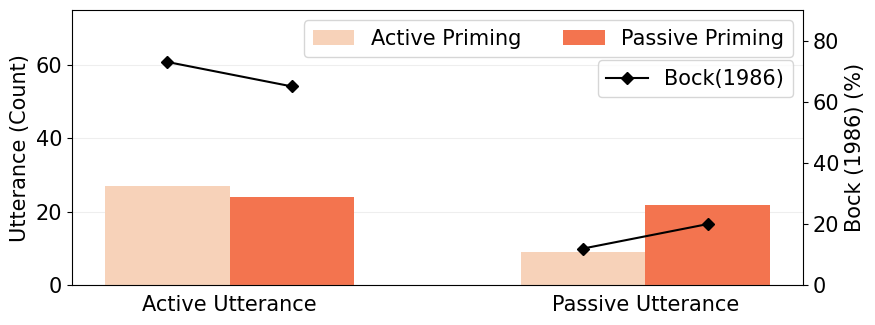

In [24]:
import matplotlib.pyplot as plt

font_size = 15
bar_width = 0.3

plt.rc('font', size=font_size) 

fig, ax = plt.subplots(figsize=(9, 3.5))

alp = 1

# ax.bar(x_pos, mean_val, yerr=mean_err, align='center', alpha=0.5, ecolor='black', capsize=10)
b1 = ax.bar(np.arange(2), [active_count_act,passive_count_act], align='center', alpha=alp, ecolor='black', capsize=10, label='Active Priming', color='#f7d2b9',
            width=bar_width)
b2 = ax.bar(np.arange(2) + bar_width, [active_count_pass,passive_count_pass,], align='center', alpha=alp, ecolor='black', capsize=10, label='Passive Priming', color='#f3744f',
            width=bar_width)

ax.set_ylim([0,75])
ax.set_ylabel('Utterance (Count)')
# ax.set_xlabel('Level of Noise')
ax.set_xticks(np.arange(2) + bar_width/2)
ax.set_xticklabels(['Active Utterance','Passive Utterance'],rotation=0)
# ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)


ax.legend(loc='upper right', ncol = 2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

x1 = [0,bar_width]
y1 = [73,65]
axes2 = plt.twinx()
axes2.plot(x1, y1, color='k', marker='D')
axes2.set_ylim(0, 90)
axes2.set_ylabel('Bock (1986) (%)')

x1 = [1,1+bar_width]
y1 = [12,20]
axes2.plot(x1, y1, color='k', marker='D',label='Bock(1986)')
axes2.legend(loc='right',bbox_to_anchor=(1,0.75))


# Save the figure and show
plt.tight_layout()
plt.savefig('retrieving.png', transparent = True)
plt.show()

In [229]:
print(passive_count_act,active_count_act,passive_count_pass,active_count_pass)

9 27 22 24


In [1]:
passive_count_act = 9
active_count_act = 27
passive_count_pass = 22
active_count_pass = 24

### Misc graphing code

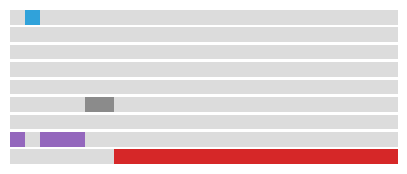

In [257]:
import colorcet as cct
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.colors as clr

aa = cjn.spec_argmax(f_act_hx_r[4:30,:9])
# aa = aa[:,1:8]
bb = np.int_(aa.squeeze())
bb = np.eye(9)[bb]
# bb = np.delete(bb, 8, 1)
cc = np.zeros((bb.shape[0],5))
# bb = np.append(bb,cc,axis=1)
# bb = np.delete(bb, 0, 1)
# bb = np.delete(bb, 7, 1)
# bb.shape

df_f = pd.DataFrame(bb, columns = ['f0','f1','f2','f3','f4','f5','f6','f7','f8']) #,'f5','f6',,'f7','f8','f9','f10','f11','f12','f13'
df_f.index.name = 'time_step'

palette = sn.color_palette(cct.glasbey_hv, 9)
# palette=sn.color_palette("Paired", 14)

#4*1.25, 2
a4_dims = (4*1.25, 2)
fig, ax = plt.subplots(nrows=9,figsize=a4_dims)
snsplt = sn.heatmap(np.expand_dims(bb[:,0], axis=0),ax=ax[0],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[0])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,1], axis=0),ax=ax[1],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[0])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,2], axis=0),ax=ax[2],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[1])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,3], axis=0),ax=ax[3],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[2])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])

snsplt = sn.heatmap(np.expand_dims(bb[:,4], axis=0),ax=ax[4],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[3])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,5], axis=0),ax=ax[5],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[4])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,6], axis=0),ax=ax[6],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[5])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])

snsplt = sn.heatmap(np.expand_dims(bb[:,7], axis=0),ax=ax[7],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[6])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,8], axis=0),ax=ax[8],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[7])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])

# snsplt = sn.heatmap(np.expand_dims(bb[:,8], axis=0),ax=ax[8],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
#                                               (1, palette.as_hex()[8])], 2),vmin=0,vmax=1,cbar=False)
# snsplt.tick_params(top = False, bottom = False,left = False, right = False)
# snsplt.set_yticks([])
# snsplt.set_xticks([])

# snsplt = sn.heatmap(np.expand_dims(bb[:,9], axis=0),ax=ax[9],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
#                                               (1, palette.as_hex()[9])], 2),vmin=0,vmax=1,cbar=False)
# snsplt.tick_params(top = False, bottom = False,left = False, right = False)
# snsplt.set_yticks([])
# snsplt.set_xticks([])
# snsplt = sn.heatmap(np.expand_dims(bb[:,10], axis=0),ax=ax[10],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
#                                               (1, palette.as_hex()[10])], 2),vmin=0,vmax=1,cbar=False)
# snsplt.tick_params(top = False, bottom = False,left = False, right = False)
# snsplt.set_yticks([])
# snsplt.set_xticks([])
# snsplt = sn.heatmap(np.expand_dims(bb[:,11], axis=0),ax=ax[11],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
#                                               (1, palette.as_hex()[11])], 2),vmin=0,vmax=1,cbar=False)
# snsplt.tick_params(top = False, bottom = False,left = False, right = False)
# snsplt.set_yticks([])
# snsplt.set_xticks([])

# snsplt = sn.heatmap(np.expand_dims(bb[:,12], axis=0),ax=ax[12],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
#                                               (1, palette.as_hex()[12])], 2),vmin=0,vmax=1,cbar=False)
# snsplt.tick_params(top = False, bottom = False,left = False, right = False)
# snsplt.set_yticks([])
# snsplt.set_xticks([])

# snsplt = sn.heatmap(np.expand_dims(bb[:,13], axis=0),ax=ax[13],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
#                                               (1, palette.as_hex()[13])], 2),vmin=0,vmax=1,cbar=False)
# snsplt.tick_params(top = False, bottom = False,left = False, right = False)
# snsplt.set_yticks([])
# snsplt.set_xticks([])

# snsplt = sn.heatmap(np.expand_dims(bb[:,14], axis=0),ax=ax[14],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
#                                               (1, palette.as_hex()[14])], 2),vmin=0,vmax=1,cbar=False)
# snsplt.tick_params(top = False, bottom = False,left = False, right = False)
# snsplt.set_yticks([])
# snsplt.set_xticks([])


# snsplt.tick_params(length=7.5)
# ax.set_yticklabels(['',''])
snsplt.tick_params(bottom = False,left = False)

snsplt.set(xlabel=None,ylabel=None)
# snsplt.get_legend().remove()

plt.savefig(fname='retrieving',transparent=True)